# Keras MNIST dataset solution

### Import required libraries

In [19]:
import keras
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import CSVLogger
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

## Load the dataset

In [20]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## Dataset visualization

We want to get a good understanding of the dataset. Here we visualize some of the data and gather some usefull stats.

#### Visualize some images

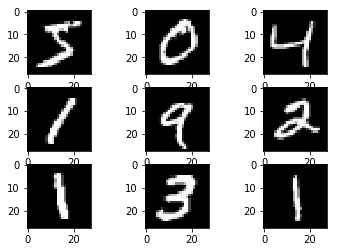

In [21]:
for row in range(3):
    for col in range(3):
        idx = row*3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(train_images[idx-1], cmap="gray")
        

#### Basic Dataset Statistics

In [22]:
num_classes = np.unique(train_labels).shape[0]
print("Number of training examples:", train_images.shape[0])
print("Number of testing examples:", test_images.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", train_images[0].shape)
print("Image data type:", test_images.dtype)

Number of training examples: 60000
Number of testing examples: 10000
Number of classes: 10
Image shape: (28, 28)
Image data type: uint8


#### Plot class distribution

<BarContainer object of 10 artists>

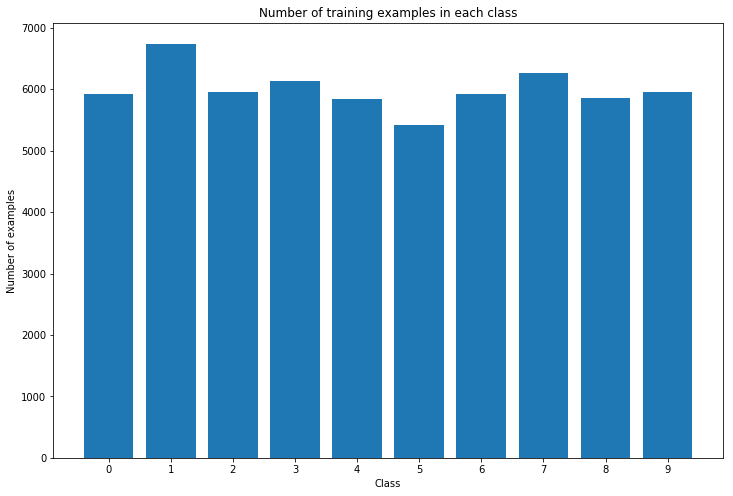

In [23]:
#reshaped_labels = [x for class_num in train_labels for x in np.where(class_num == 1)[0]]
class_distribution = Counter(train_labels)
x = range(10)
y = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of training examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, y)

### Data pre-processing
Pre-processing is an important step.

We perform pixel-wise normalization to make all features have a uniform scale. This helps remove biases in the model.

In [24]:
# normalize dataset using z-score
pixel_mean = train_images.mean(axis=0)
pixel_std = train_images.std(axis=0) + 1e-10
train_images = (train_images - pixel_mean) / pixel_std
test_images = (test_images - pixel_mean) / pixel_std

#### Visualize the normalized data

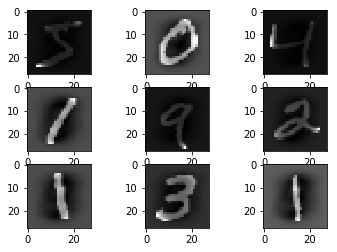

In [25]:
for row in range(3):
    for col in range(3):
        idx = row*3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(train_images[idx-1], cmap="gray")
        

#### Transform labels to a binary class matrix

In [26]:
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

### Change data shape
Since we are using the tensorflow backend, it expects the images to be in the shape (60000, 28, 28, 1). Here we use numpy to reshape the image to the correct format and layout.

In [27]:
# reshape (60000, 28, 28) to (60000, 28, 28, 1)
train_images = train_images[:,:,:, np.newaxis].astype(np.float32)
test_images = test_images[:,:,:, np.newaxis].astype(np.float32)

## Model Construction

Here we will build a very simple fully connected neural network, with the following layers:

- Flatten layer. Required to feed into our fully-connected layer. 
- Dense (hidden) layer with 32 neurons
- Dropout "layer" with drouput = 25%, randomly setting the values of 25% of the inputs
- Output layer with 10 output-neurons (for the 10 output classes)

We use a relu-activation function in all the hidden layers, and a softmax-activation in the output layer. The softmax-activation provides a probability distribution over the ouput classes.

In [28]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=train_images.shape[1:]))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(10, activation='softmax'))
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### Compilation, optimization function and loss metric

We then compile our model where the inputs are the following:

- Loss: the function we want to minimize. In our case we use categorical_crossentropy. It is widely used and is covered in this course. 
- Optimizer: adam is a well-known and good optimizer. It is an extention of stochastic gradient descent that proved to work quite well with our model.

In [29]:
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


In [30]:
def fit_save_network(network, epochs, name=None):
    ''' Fit and save a network, or load from disk '''
    print()
    network.summary()
    if not os.path.isfile('{}.csv'.format(str(name))) or not os.path.isfile('{}.h5'.format(str(name))):
        csv_logger = CSVLogger('{}.csv'.format(str(name)), 
                               separator=',', 
                               append=False)
        network.fit(train_images, train_labels,
                  batch_size=128,
                  epochs=epochs,
                  validation_split = 0.25,
                  callbacks = [csv_logger])
        # serialize weights to HDF5
        network.save_weights('{}.h5'.format(str(name)))
        print('Saved model to disk')
        history = network.history.history
    else:
        log_data = pd.read_csv('{}.csv'.format(str(name)), 
                               sep=',', 
                               engine='python')
        network.load_weights('{}.h5'.format(str(name)))
        print('Loaded model from disk')
        history = log_data

    test_loss, test_acc = network.evaluate(test_images, test_labels)
    print('test_acc:', test_acc)

    return network, history

#### Saving the model to disk
We save the model to disk, this way we don't have to retrain every single time we rerun this program

We set the number of epochs we want to train for, and also the batch size we want to use.

The model is evaulated after each epoch on the validation set.

In [31]:
epochs = 15
network, history = fit_save_network(network, epochs, 'simple')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Loaded model from disk
10000/10000 [==============================] - 2s 169us/step
test_acc: 0.9543


## Evaluation

By evaluating the model we see a 95.4% accuracy on the test-set, with a 0.1779 test loss.

In [32]:
final_loss, final_accuracy = network.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

10000/10000 [==============================] - 1s 85us/step
The final loss on the test set is: 0.17789694944676013
The final accuracy on the test set is: 0.9543


## Plots
Here we plot the losses and accuracies to determine if the model is good or not - it also gives an indication of overfitting.

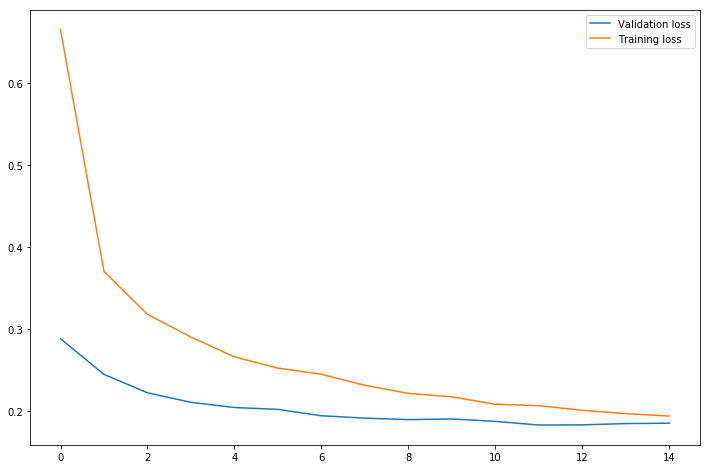

In [33]:
# plot losses
plt.figure(figsize=(12, 8))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.show()

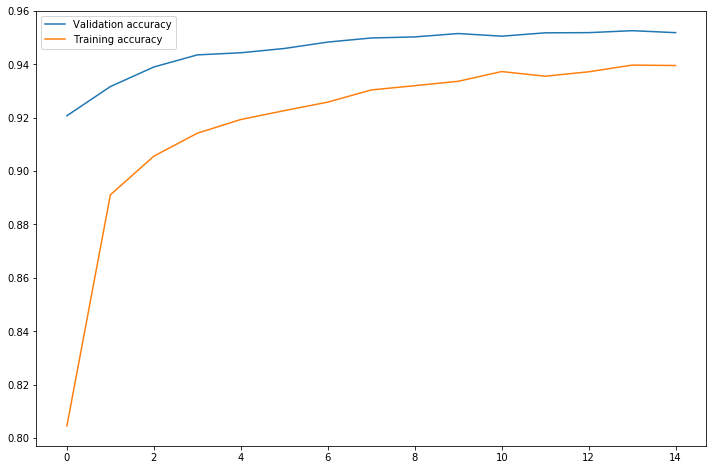

In [34]:
# plot accuracy
plt.figure(figsize=(12, 8))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.plot(history['acc'], label='Training accuracy')
plt.legend()
plt.show()

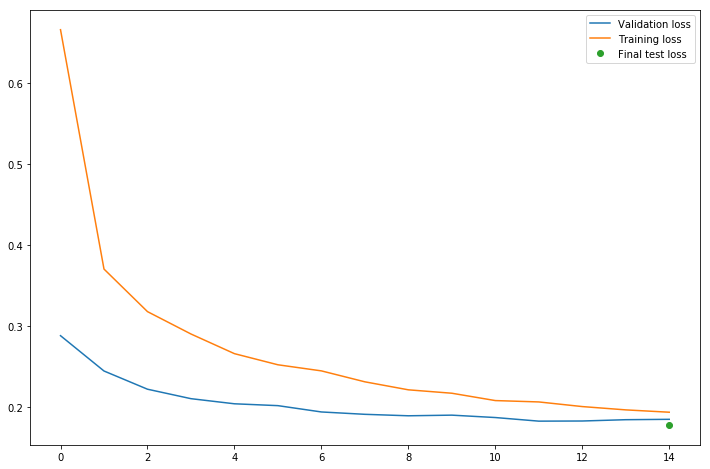

In [35]:
# plot final losses
plt.figure(figsize=(12, 8))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

## Conclusion
As we see, the validation-loss is still slightly decreasing and is not deviating from the final test loss nor the training loss. This is an indication of a good model with minimal overfitting/bias.

## Best model (97.5%)

This is our best model, achieving 97.5% accuracy with almost no overfitting.

We use the same model-architecture as in the simple model. This time we have 3 hidden layers with 256 neurons in each. We also use dropout = 25% in each layer.

Same optimizer and loss-function.

We run with fewer epochs to not overfit the model - this is quite a complex model for this problem, so training with too many epochs easily yields 99.9% accuracy with highly fluctuating and deviating losses.

In [36]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=train_images.shape[1:]))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 10
network, history = fit_save_network(network, epochs, 'best')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________

## Evaluation
We get a final accuracy of 97.5% and a test loss of 0.1126

In [37]:
final_loss, final_accuracy = network.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

10000/10000 [==============================] - 1s 112us/step
The final loss on the test set is: 0.11263050542582059
The final accuracy on the test set is: 0.9749


### Plots
More loss- and accuracy plots. 

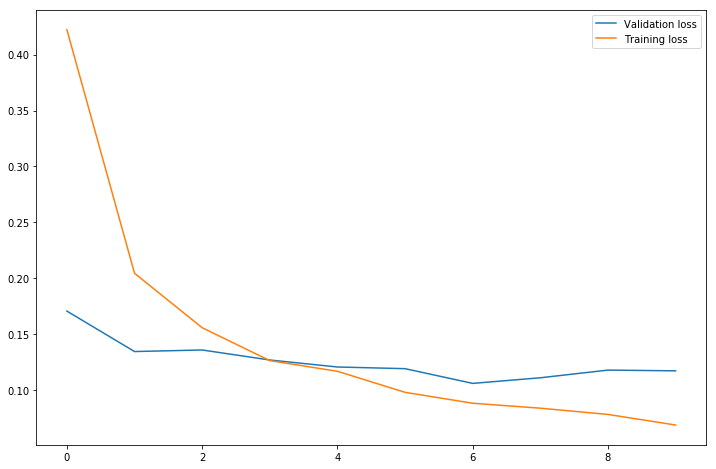

In [39]:
# plot losses
plt.figure(figsize=(12, 8))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.show()

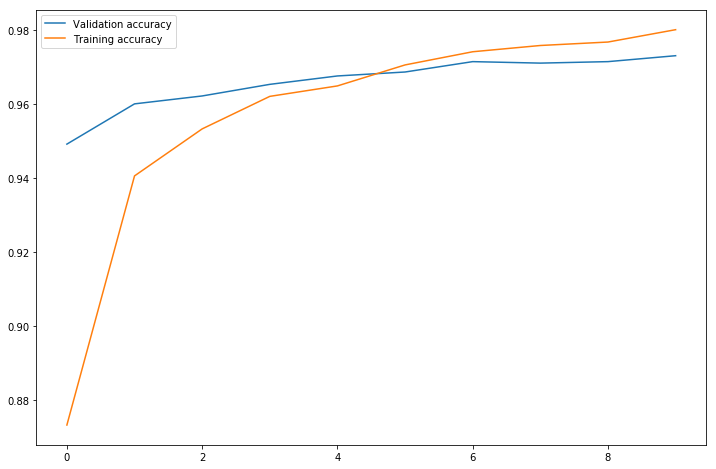

In [40]:
# plot accuracy
plt.figure(figsize=(12, 8))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.plot(history['acc'], label='Training accuracy')
plt.legend()
plt.show()

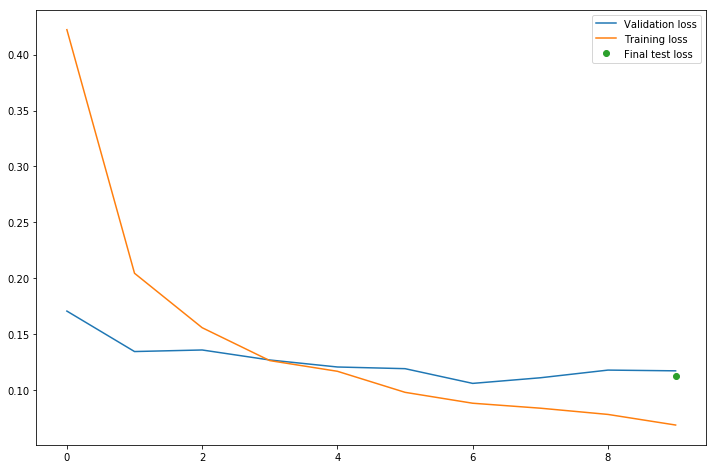

In [41]:
# plot final losses
plt.figure(figsize=(12, 8))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

We see that the test-loss is very close to the validation loss - which is good. However, the training loss and validation loss are starting to move away from eachother. This is a clear indication of the model overfitting if trained for too many epochs. 

### Use of dropout
The use of dropout here was crucial. The model is too complex for running 10 epochs without randomly dropping out parts of the layers. This is the result we got from running the same model without any dropout

In [42]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=train_images.shape[1:]))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 10
network, history = fit_save_network(network, epochs, 'best_overfitting')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
_________________________________________________________________
Loaded model from disk
10000/10000 [==============================] - 2s 205us/step
test_acc: 0.9717


In [43]:
final_loss, final_accuracy = network.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

10000/10000 [==============================] - 1s 109us/step
The final loss on the test set is: 0.15210933405004945
The final accuracy on the test set is: 0.9717


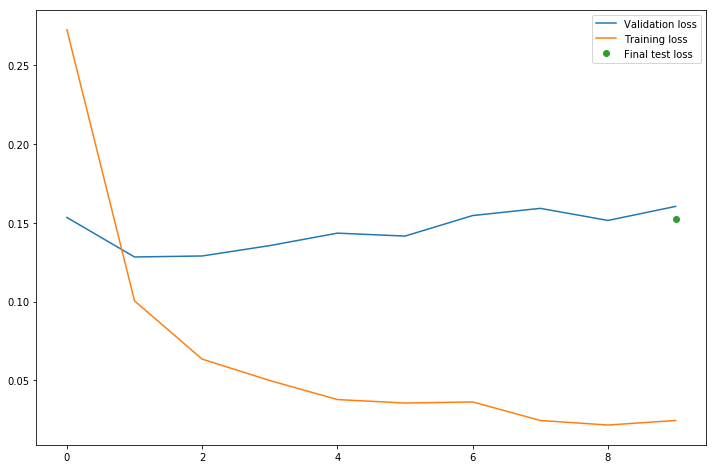

In [45]:
# plot final losses
plt.figure(figsize=(12, 8))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

It is clear that dropout has a big influence on this  model. There is a colossal difference in training and validation loss otherwise. 

## More evaluation

In [46]:
def plot_classification_report(plotMat, classes):
    ''' Plots the classification report from scikit-learn as a heatmap '''
    title='Precision-recall report'
    plt.figure(figsize=(10, 5))
    plt.imshow(plotMat, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    y_tick_marks = np.arange(3)
    x_tick_marks = np.arange(len(classes))
    plt.yticks(y_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.xticks(x_tick_marks, classes)
    #plt.tight_layout()
    plt.xlabel('Classes')
    plt.ylabel('Measures')
    plt.show()

10000/10000 [==============================] - 1s 66us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.95      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.95      0.98      0.97       974
           9       0.96      0.97      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



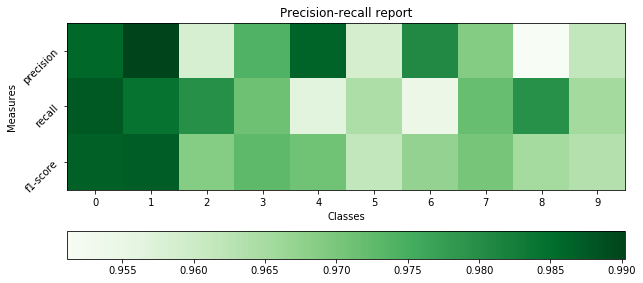

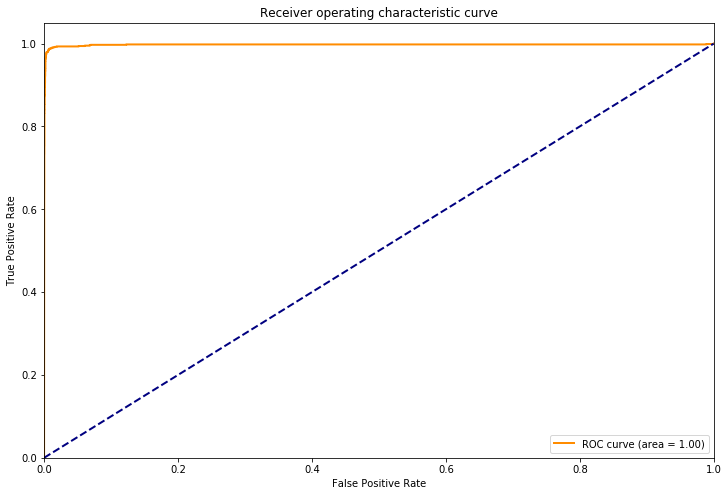

In [48]:
def visualize_precision_recall(network, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    ''' 
    #test_score = history.decision_function(test_images)
    pred = network.predict(test_images, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(test_labels, axis=1),
            predicted)
    probas = network.predict_proba(test_images)
    print(report)

    # need to do this again to get the dictionary for plots :S
    report = classification_report(np.argmax(test_labels, axis=1), predicted,
            output_dict=True)

    plotMat = []
    classes = [0,1,2,3,4,5,6,7,8,9]
    precision = []
    recall = []
    f1 = []
    for k, v in report.items():
        precision.append(v.get('precision'))
        recall.append(v.get('recall'))
        f1.append(v.get('f1-score'))
    plotMat.append(precision[:10])
    plotMat.append(recall[:10])
    plotMat.append(f1[:10])
    plot_classification_report(plotMat, classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    
visualize_precision_recall(network, epochs)